In [98]:
import pandas as pd
import requests
import base64
from PIL import Image
from io import BytesIO
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import numpy as np

In [99]:
file_path = '/content/A2_Data - A2_Data.csv'
column_names = ['Product ID.', 'Image', 'Review text']
df = pd.read_csv(file_path,names=column_names)
df = df.drop(0)
df = df.reset_index(drop=True)


In [4]:
df

,Product ID.,Image,Review text
0,3452.0,['https://images-na.ssl-images-amazon.com/imag...,Loving these vintage springs on my vintage str...
1,1205.0,['https://images-na.ssl-images-amazon.com/imag...,Works great as a guitar bench mat. Not rugged ...
2,1708.0,['https://images-na.ssl-images-amazon.com/imag...,We use these for everything from our acoustic ...
3,2078.0,['https://images-na.ssl-images-amazon.com/imag...,Great price and good quality. It didn't quite...
4,801.0,['https://images-na.ssl-images-amazon.com/imag...,I bought this bass to split time as my primary...
...,...,...,...
995,1265.0,['https://images-na.ssl-images-amazon.com/imag...,Extremely impressed with this kit.
996,1882.0,['https://images-na.ssl-images-amazon.com/imag...,This is a great stereo reverb with plenty of c...
997,1547.0,['https://images-na.ssl-images-amazon.com/imag...,I really like the simplicity of this bridge. I...
998,1004.0,['https://images-na.ssl-images-amazon.com/imag...,"Great Product, but there is no warranty in the..."


In [100]:
image_column = "Image"
for index, row in df.iterrows():
    image_url = row[image_column]
    images = image_url.strip('[]').split(',')
    images = [value.strip().strip("'") for value in images]
    df.at[index, image_column] = images



In [101]:

df = df.explode('Image')
df.reset_index(drop=True, inplace=True)
df["image_links"] = df["Image"]


In [102]:
def url_to_image(url):

    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            return img
        else:
            return None
    except Exception as e:
        print(f"Error downloading image from {url}: {e}")
        return None
def preprocess_images(url):
    preprocessed_images = []

    image = url_to_image(url)
    if image is not None:
        preprocessed_images.append(image)
    return preprocessed_images

# Apply preprocessing and filter rows with no valid images
df['Image'] = df['Image'].apply(preprocess_images)
df = df[df['Image'].apply(len) > 0]

In [103]:
def adjust_contrast(image, factor=1.2):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

# Function to resize an image to a specified size
def resize_image(image, size=(100, 100)):
    return image.resize(size)

# Function to adjust brightness and exposure of an image
def adjust_brightness(image, factor=1.2):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)


In [104]:
def preprocessing(urls):
  preprocessed_images = []
  for image in urls:
        image = adjust_contrast(image)
        image = resize_image(image)
        image = adjust_brightness(image)
        preprocessed_images.append(image)
  return preprocessed_images

df['Image'] = df['Image'].apply(preprocessing)

In [105]:
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pickle

In [106]:
model = VGG16(weights='imagenet', include_top=False)
def normalize_features(features):
    min_val = np.min(features)
    max_val = np.max(features)
    normalized_features = (features - min_val) / (max_val - min_val)
    return normalized_features

In [ ]:

def extract_features(images):
    image_features = []
    for img in images:
            img = img.resize((100, 100))  # Resize image to VGG16 input size
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            features = model.predict(x)
            image_features.append(features)  # Store extracted features
    return image_features
df['Image_Features'] = df['Image'].apply(extract_features)


df['Image_Features'] = df['Image_Features'].apply(lambda x: [normalize_features(feature) for feature in x])


import pickle
with open('/content/extracted_features.pkl', 'wb') as f:
    pickle.dump(df['Image_Features'], f)

In [107]:
with open('/content/extracted_features.pkl', 'rb') as f:
    data = pickle.load(f)
    df['Image_Features'] = data

#Part 2

In [108]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from nltk.tokenize import TweetTokenizer
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
tokenizer = TweetTokenizer()
patterns = r"\b(?:[a-zA-Z](?:[a-zA-Z'_]*[a-zA-Z])?|(?<![_-])['_-](?![_-]))\b"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [109]:
def preprocess_text(text):
    # Lower-casing
    if pd.isnull(text) or text.strip() == '':
        return None
    lowercase_content = text.lower()
    tokens = re.findall(patterns, lowercase_content)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token.strip()]


    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Apply text preprocessing to the 'Review text' column
df['Processed Review'] = df['Review text'].apply(preprocess_text)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 0 to 1647
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID.       1640 non-null   float64
 1   Image             1640 non-null   object 
 2   Review text       1639 non-null   object 
 3   image_links       1640 non-null   object 
 4   Image_Features    1640 non-null   object 
 5   Processed Review  1639 non-null   object 
dtypes: float64(1), object(5)
memory usage: 89.7+ KB


In [111]:
from collections import Counter
def calculate_tf(review):
    tf_dict = {}
    if review == None:
        return None

    word_count = len(review)
    word_freq = Counter(review)
    for word, freq in word_freq.items():
        tf_dict[word] = freq / word_count
    return tf_dict

df['TF'] = df['Processed Review'].apply(calculate_tf)


In [112]:
import math
def calculate_idf(corpus):
    total_docs = len(corpus)
    idf_dict = {}
    word_doc_freq = {}
    for doc in corpus:
        if doc is None:
            continue
        unique_words = set(doc)
        for word in unique_words:
            word_doc_freq[word] = word_doc_freq.get(word, 0) + 1
    for word, freq in word_doc_freq.items():
        idf_dict[word] = math.log(total_docs / freq)
    return idf_dict

corpus = df['Processed Review'].tolist()
idf_dict = calculate_idf(corpus)

In [ ]:
idf_dict

In [113]:
def calculate_tfidf(tf_dict, idf_dict):
    if not tf_dict:  # Check if tf_dict is empty (None review)
        return {}
    tfidf_dict = {}
    for word, tf in tf_dict.items():
        tfidf_dict[word] = tf * idf_dict.get(word, 0)
    return tfidf_dict

df['TF-IDF'] = df['TF'].apply(lambda x: calculate_tfidf(x, idf_dict))

In [18]:
with open('/content/tf-idf.pkl', 'wb') as f:
    pickle.dump(df['TF-IDF'], f)

#Part 3


In [114]:
def download_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        return img
    else:
        print(f"Failed to download image from URL: {url}")
        return None

In [116]:
input_image_url = input("enter url of the image: ")
input_image = download_image(input_image_url)


enter url of the image: https://images-na.ssl-images-amazon.com/images/I/61Yuwnt9eoL._SY88.jpg


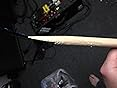

In [117]:
input_image

In [118]:

img = input_image.resize((100, 100))  # Resize image to VGG16 input size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = model.predict(x)
features = normalize_features(features)


1/1 [==============================] - 0s 137ms/step


In [119]:
def flatten_array(lst):
    arr = np.array(lst)
    arr = arr.reshape(-1)
    return arr

# Apply the function to each element of the DataFrame column
df['Image_Features'] = df['Image_Features'].apply(flatten_array)
features = features.reshape(-1)

In [130]:
row = df[df['image_links'] == input_image_url]

# Retrieve the product ID from the row
if not row.empty:
    product_id = row.iloc[0]['Product ID.']
    product_review = row.iloc[0]['Processed Review']
    tfidf = row.iloc[0]['TF-IDF']
    print("Product ID:", product_id)
else:
    print("Image link not found in DataFrame.")

Product ID: 216.0


In [121]:
def dict_to_vector(dictionary, vocabulary):
    vector_length = len(vocabulary)
    vector = np.zeros(vector_length)
    for key, value in dictionary.items():
        if key in vocabulary:
            index = vocabulary.index(key)
            vector[index] = value
    return vector

In [133]:
product_id

216.0

In [135]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'features' and 'product_id' are already defined
flat_input_features = features.flatten()

# Calculate cosine similarity between input features and each array in the DataFrame column
cos_similarities = []

# Store product IDs of images already considered

for index, row in df.iterrows():
    # Exclude images with the same product ID as the input image
    if row['Product ID.'] == product_id:
        continue
    if row['Product ID.'] == product_id:
        print(product_id)
        continue

    # Check if the product ID has already been considered


    resized_array = np.resize(row['Image_Features'], features.shape)
    flat_array = resized_array.flatten()
    cos_sim = cosine_similarity(flat_input_features.reshape(1, -1), flat_array.reshape(1, -1))
    cos_similarities.append((index, cos_sim[0][0]))

    # Add the product ID to the set of considered IDs

# Sort similarity scores in descending order
cos_similarities.sort(key=lambda x: x[1], reverse=True)

# Retrieve top three most similar images
top_three_similar_images = cos_similarities[:3]
top_three_similar_images

[(1312, 0.33284348), (713, 0.2829513), (721, 0.27994642)]

In [149]:
review_cosine = []
for index, similarity_score in top_three_similar_images:
  tfidf_dict1 = tfidf
  tfidf_dict2 = df.loc[index,'TF-IDF']
  vocabulary = list(set(tfidf_dict1.keys()) | set(tfidf_dict2.keys()))
  tfidf_vector1 = dict_to_vector(tfidf_dict1, vocabulary)
  tfidf_vector2 = dict_to_vector(tfidf_dict2, vocabulary)
  cosine_sim = cosine_similarity([tfidf_vector1], [tfidf_vector2])
  review_cosine.append(cosine_sim[0][0])




# Print top three similar images along with their URLs, product reviews, and product IDs
i=0
for index, similarity_score in top_three_similar_images:
    image_link = df.loc[index, 'image_links']
    product_review = df.loc[index, 'Review text']
    product_id = df.loc[index, 'Product ID.']
    print("Product ID:", product_id)
    print("Image link:", image_link)
    print("Product review:", product_review)
    print("Cosine similarity score of image:", similarity_score)
    print("Cosine similarity score of text:",review_cosine[i])
    i+=1
    print()


Product ID: 2760.0
Image link: https://images-na.ssl-images-amazon.com/images/I/71J9ItBhxPL._SY88.jpg
Product review: Just what I needed, although at it's lowest setting, wass about an inch too tall for me sitting on the edge of my bed. Ive gotten used to it now so it's all good! Like others have said, it's good quality and sturdy construction. I stubbed my toe on it in The night, and quickly wished that hadn't happened! The rubber grip on top is actually riveted on, so that should last a good while. I also used this for when I practice standing up. I rest my foot on it which pushes the bottom of my guitars out so I can see what I'm doing. All in all its a good product and I recommend it. A word of warning, this is made of strong metal, if you're buying this for your son or daughter, show them the dangers of the scissoring action of the legs. I imagine they could do some hurtin to little fingers.
Cosine similarity score of image: 0.33284348
Cosine similarity score of text: 0.0355579561

Ranking on the basis of the composite score

In [151]:
composite_scores = [(index, (similarity_score + review_cosine[i]) / 2) for i, (index, similarity_score) in enumerate(top_three_similar_images)]
composite_scores = sorted(composite_scores, key=lambda x: x[1], reverse=True)

for index, composite_score in composite_scores:
    image_link = df.loc[index, 'image_links']
    product_review = df.loc[index, 'Review text']
    product_id = df.loc[index, 'Product ID.']
    print("Product ID:", product_id)
    print("Image link:", image_link)
    print("Product review:", product_review)
    print("Composite similarity score:", composite_score)
    print()


Product ID: 2760.0
Image link: https://images-na.ssl-images-amazon.com/images/I/71J9ItBhxPL._SY88.jpg
Product review: Just what I needed, although at it's lowest setting, wass about an inch too tall for me sitting on the edge of my bed. Ive gotten used to it now so it's all good! Like others have said, it's good quality and sturdy construction. I stubbed my toe on it in The night, and quickly wished that hadn't happened! The rubber grip on top is actually riveted on, so that should last a good while. I also used this for when I practice standing up. I rest my foot on it which pushes the bottom of my guitars out so I can see what I'm doing. All in all its a good product and I recommend it. A word of warning, this is made of strong metal, if you're buying this for your son or daughter, show them the dangers of the scissoring action of the legs. I imagine they could do some hurtin to little fingers.
Composite similarity score: 0.18420071930902393

Product ID: 2725.0
Image link: https://im

In [170]:
input_image_review= input("enter review of the image: ")
input_image_review = preprocess_text(input_image_review)
row = df[df['Processed Review'].apply(lambda x: x == input_image_review)]


# Retrieve the product ID from the row
if not row.empty:
    product_id = row.iloc[0]['Product ID.']
    product_url = row.iloc[0]['image_links']
    tfidf = row.iloc[0]['TF-IDF']
    input_features = row.iloc[0]['Image_Features']
    print("Product ID:", product_id)
    print("product url:",product_url)
else:
    print("Image review not found in DataFrame.")




enter review of the image: We use these for everything from our acoustic bass down to our ukuleles. I know there is a smaller model available for ukes, violins, etc.; we haven't yet ordered those, but these will work on smaller instruments if one doesn't extend the feet to their maximum width. They're gentle on the instruments, and the grippy material keeps them secure.  The greatest benefit has been when writing music at the computer and needing to set a guitar down to use the keyboard/mouse - just easier for me than a hanging stand.  We have several and gave one to a friend for Christmas as well. I've used mine on stage, and it folds up small enough to fit right in my gig bag.
Product ID: 1708.0
product url: https://images-na.ssl-images-amazon.com/images/I/71Md5ihUFLL._SY88.jpg


In [171]:
product_id

1708.0

In [172]:
from sklearn.metrics.pairwise import cosine_similarity
cos_similarities = []

# Store product IDs of images already considered
considered_ids = set()
considered_ids.add(product_id)
print(considered_ids)

for index, row in df.iterrows():
    # Exclude images with the same product ID as the input image
    if row['Product ID.'] in considered_ids:
      continue
    if row['Product ID.'] in considered_ids:
      continue
    considered_ids.add(row['Product ID.'])
    if row['Product ID.'] == product_id:
      print("hi")

    tfidf_dict1 = tfidf
    tfidf_dict2 = row['TF-IDF']
    vocabulary = list(set(tfidf_dict1.keys()) | set(tfidf_dict2.keys()))


    tfidf_vector1 = dict_to_vector(tfidf_dict1, vocabulary)
    tfidf_vector2 = dict_to_vector(tfidf_dict2, vocabulary)



    cosine_sim = cosine_similarity([tfidf_vector1], [tfidf_vector2])
    cos_similarities.append((index, cosine_sim[0][0]))


# Sort similarity scores in descending order
cos_similarities.sort(key=lambda x: x[1], reverse=True)


top_three_similar_reviews = cos_similarities[:3]
top_three_similar_reviews

{1708.0}


[(241, 0.170746742308244),
 (1031, 0.14409138801340432),
 (803, 0.1409550890236484)]

In [173]:


input_features = np.array(input_features)
input_features=input_features.flatten()
image_cos_sim = []
for index,similarity_score in top_three_similar_reviews:
    resized_array = np.resize(df.loc[index,'Image_Features'], input_features.shape)
    flat_array = resized_array.flatten()
    cos_sim = cosine_similarity(input_features.reshape(1, -1), flat_array.reshape(1, -1))
    image_cos_sim.append(cos_sim[0][0])


# Print top three similar images along with their URLs, product reviews, and product IDs
i=0
for index, similarity_score in top_three_similar_reviews:
    image_link = df.loc[index, 'image_links']
    product_review = df.loc[index, 'Review text']
    product_id = df.loc[index, 'Product ID.']
    image = df.loc[index,'image_links']
    print("Product ID:", product_id)
    print("Product review:", product_review)
    print("Product Image:", image)
    print("Cosine similarity score of text:",similarity_score)
    print("Cosine similarity score of Image:",image_cos_sim[i])
    i+=1
    print()




Product ID: 2281.0
Product review: This is a nice stand, but it doesn't work great for my concert-sized ukulele.  It's definitely durable and adjustable, but it's a little too large for my instrument.  I have tried to pull the legs of the stand closer together in order to better accommodate the size of my ukulele, but in doing that, it feels a bit unstable.  If you're looking for a compact, inexpensive stand, I would definitely recommend this one, but just be aware that it might not work as well for smaller instruments.
Product Image: https://images-na.ssl-images-amazon.com/images/I/71cp5HvMnBL._SY88.jpg
Cosine similarity score of text: 0.170746742308244
Cosine similarity score of Image: 0.22483307

Product ID: 747.0
Product review: I own a Yamaha 61 keys Keyboard and I ordered this stand because the product description says it is Yamaha make. But what is written on the box is:'Keyboard Stand For Portable Keyboards from Yamaha and Others' and there is no Yamaha emblem neither on the bo

In [174]:
composite_scores = [(index, (similarity_score + review_cosine[i]) / 2) for i, (index, similarity_score) in enumerate(top_three_similar_reviews)]
composite_scores = sorted(composite_scores, key=lambda x: x[1], reverse=True)

for index, composite_score in composite_scores:
    image_link = df.loc[index, 'image_links']
    product_review = df.loc[index, 'Review text']
    product_id = df.loc[index, 'Product ID.']
    print("Product ID:", product_id)
    print("Image link:", image_link)
    print("Product review:", product_review)
    print("Composite similarity score:", composite_score)
    print()


Product ID: 2281.0
Image link: https://images-na.ssl-images-amazon.com/images/I/71cp5HvMnBL._SY88.jpg
Product review: This is a nice stand, but it doesn't work great for my concert-sized ukulele.  It's definitely durable and adjustable, but it's a little too large for my instrument.  I have tried to pull the legs of the stand closer together in order to better accommodate the size of my ukulele, but in doing that, it feels a bit unstable.  If you're looking for a compact, inexpensive stand, I would definitely recommend this one, but just be aware that it might not work as well for smaller instruments.
Composite similarity score: 0.1031523492159688

Product ID: 578.0
Image link: https://images-na.ssl-images-amazon.com/images/I/71byMFii2FL._SY88.jpg
Product review: These are very sturdy and useful. I have one for gigs, one for busking, and a backup. I prefer hanging my violin on a stand than laying it in my case. It feels more secure and I have quick access.
Composite similarity score: 0

#Part 5.b

Quantitatively, image retrieval using features gives better results because all the images are very similar. The VGG16 model extracts high-level features from images, which encode rich information about their visual content. Since the images are similar, the extracted features likely capture the key visual aspects that distinguish them. As a result, cosine similarity scores calculated from these features can effectively measure the similarity between images, leading to accurate retrieval results.

Qualitatively, reviews give better results since they include more detail about the images. Reviews provide textual descriptions that encapsulate various aspects of the images such as composition, context, emotions evoked, and specific details not captured solely by visual features. By computing cosine similarity scores between the TF-IDF representations of reviews, the semantic similarity between textual descriptions can be effectively captured. This allows for a more nuanced understanding of the images, considering the additional information provided by the reviews.

In summary, while image retrieval based on feature similarity performs better quantitatively due to the similarity of images, qualitatively, reviews provide richer context and detail, enhancing the overall similarity assessment.

#Part 5.c

##Challenges:
Feature Representation: The choice of features used for calculating cosine similarity greatly impacts retrieval performance. Ensuring that the features capture relevant characteristics of the images is crucial. It may require experimentation with different feature extraction techniques to find the most suitable ones.

Dimensionality: High-dimensional feature vectors can lead to increased computational complexity and memory usage, especially when dealing with large datasets.



##Improvements:

Fine-tuning Feature Extraction: Continuously fine-tuning the feature extraction process to better capture relevant image characteristics can lead to improved retrieval performance. This may involve exploring advanced feature extraction techniques or leveraging pre-trained deep learning models.

Ensemble Methods: Combining multiple feature extraction methods or similarity metrics through ensemble methods can potentially enhance retrieval accuracy. Ensemble techniques such as bagging or boosting can be applied to achieve better overall performance.

